In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import math
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/train.csv.zip
/kaggle/input/allstate-claims-severity/sample_submission.csv.zip
/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/test.csv
/kaggle/input/allstate-claims-severity/test.csv.zip


Import ML packages

In [2]:
train = pd.read_csv("../input/allstate-claims-severity/train.csv")
test = pd.read_csv("../input/allstate-claims-severity/test.csv")

Get train data and test data dimension

In [3]:
print(train.shape)
print(test.shape)

(188318, 132)
(125546, 131)


We are predicting the 'loss' variable. Summarize the 'loss' column

In [4]:
train.loss.describe()
print(train.dtypes)

id          int64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


Check the distribution of 'loss' value[](http://)

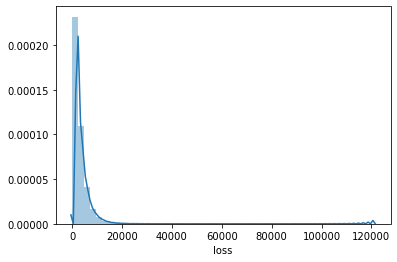

In [5]:
sns.distplot(train["loss"])

Observed that 'loss' value is right skewed. We will see if log-transformation will correct the skewness

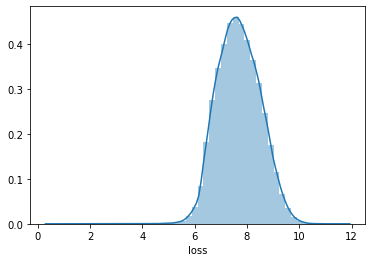

In [6]:
log_loss = np.log1p(train["loss"])
sns.distplot(log_loss)

After log-transformation, distribution of 'loss' value become more normal. 
Therefore, in later models, we will try to log-transform the train data.

In [7]:
cols = list((train.dtypes == 'object')[(train.dtypes == 'object')].index)
print('There are' + ' ' + str(len(cols)) + ' Categorical Variables')
print(cols)

There are 116 Categorical Variables
['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', '

Observed that value for the categorical variables are all letters. They need to be one hot encoded.

Also consider that multicollinearity exists among the variables. Need to remove correlated features, features that are not properly distributed, and also features with less correlation with 'loss' value.

In [8]:
train_data = train.copy()
test_data = test.copy()
merged_data = train_data.append(test_data)
print(train_data.shape)
print(test_data.shape)
print(merged_data.shape)

(188318, 132)
(125546, 131)
(313864, 132)


Find correlation between the continuous variables

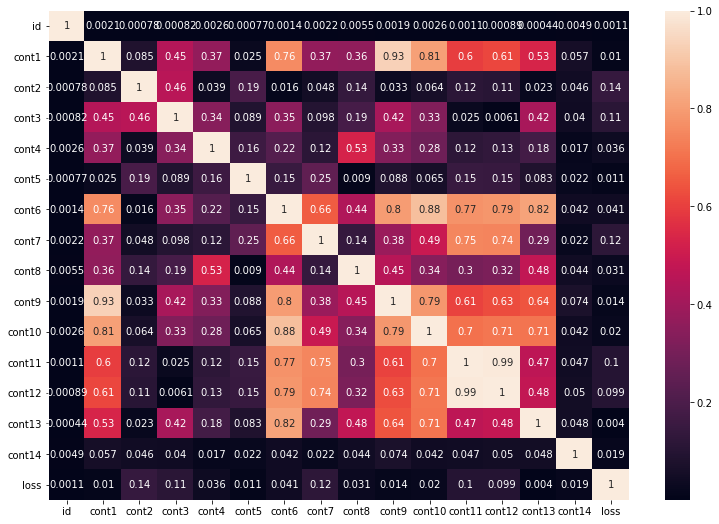

In [9]:
cor_matrix = train_data.corr().abs()
plt.subplots(figsize=(13, 9))
sns.heatmap(cor_matrix,annot=True)
plt.show()

Dropp features within a pair that has high correlation - mitigate multicollinearity.
**Parameter to tune: cor value 0.75**

In [10]:
features_to_drop = set()
feature_list = [x for x in cor_matrix]
n = len(feature_list)
for i in range(n):
    for j in range(i+1, n):
        f1 = feature_list[i]
        f2 = feature_list[j]
        if abs(cor_matrix[f1][f2]) > 0.75: features_to_drop.add(f1)

In [11]:
print(features_to_drop)

{'cont6', 'cont1', 'cont9', 'cont11'}


In [12]:
merged_data_dropped = merged_data.drop(features_to_drop, axis = 1)

Now drop features with low correlation with the 'loss' variable.
**Parameter to be tuned: corr value 0.030**

In [13]:
quant_features = list((train_data.dtypes == 'flot64')[train_data.dtypes == 'float64'].index)
quant_features = [i for i in quant_features if i not in features_to_drop]
features_to_drop_low_target_cor = set()
for i in quant_features:
    if abs(train_data[i].corr(train_data["loss"])) < 0.030:
        features_to_drop_low_target_cor.add(i)
features_to_drop_low_target_cor

{'cont10', 'cont13', 'cont14', 'cont5'}

In [14]:
merged_data_dropped = merged_data_dropped.drop(features_to_drop_low_target_cor, axis = 1)

In [15]:
merged_data_dropped.shape

(313864, 124)

Now we need to study the distribution of each feature, and drop features with abnormal distribution (categorical features only)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


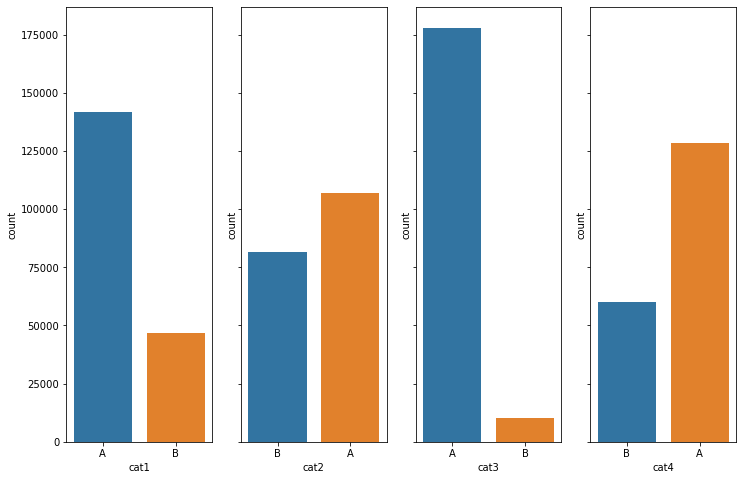

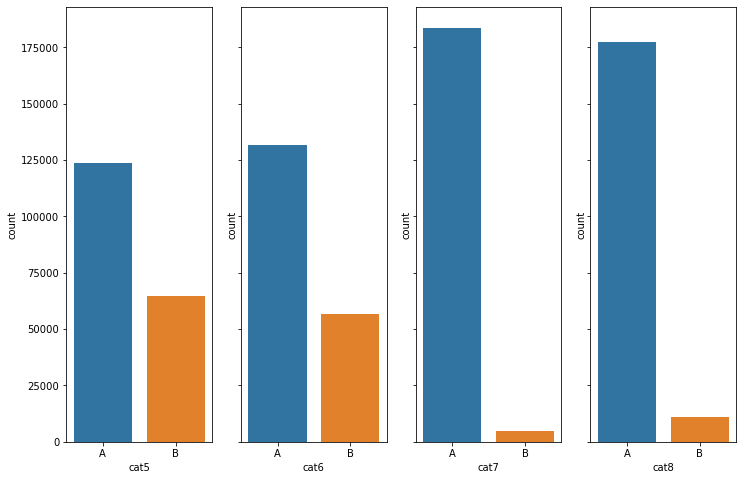

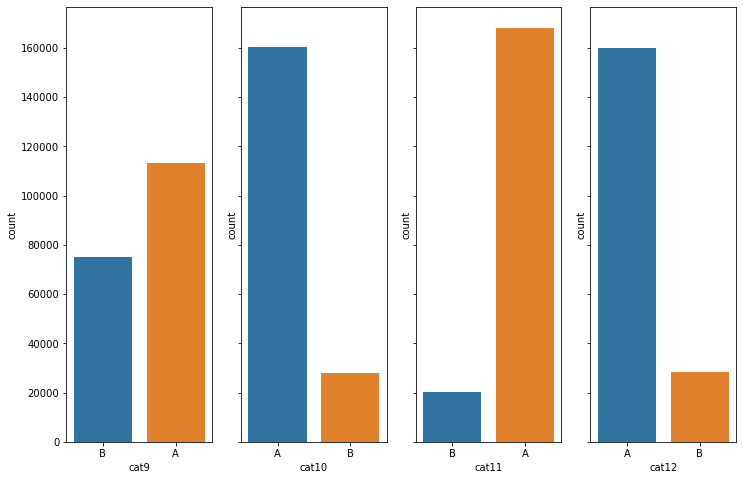

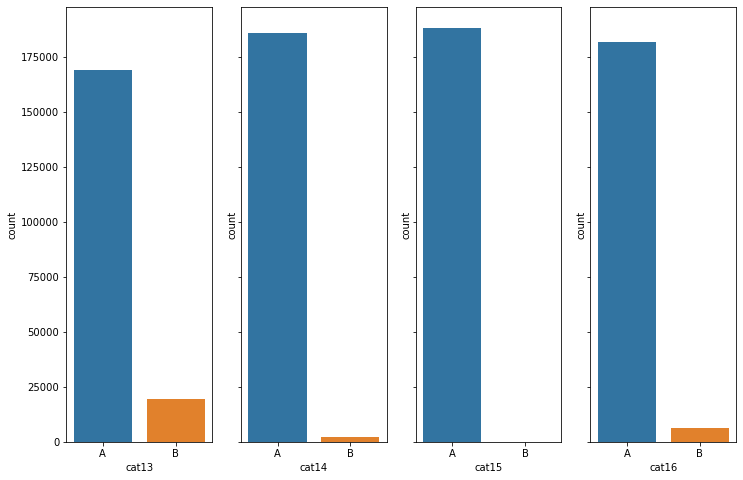

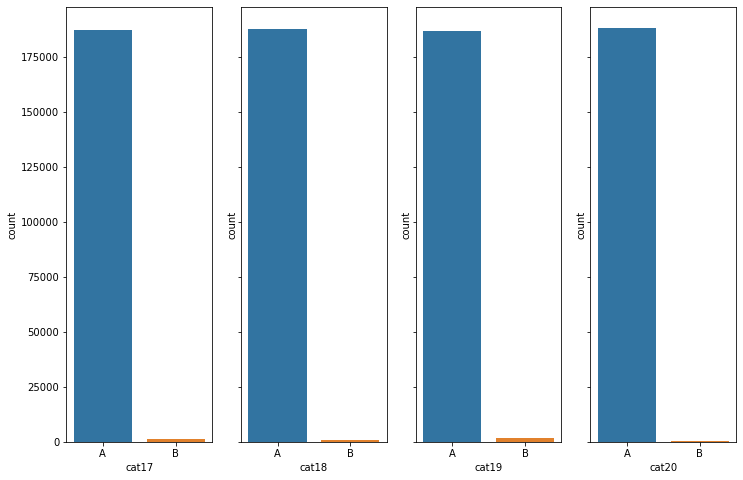

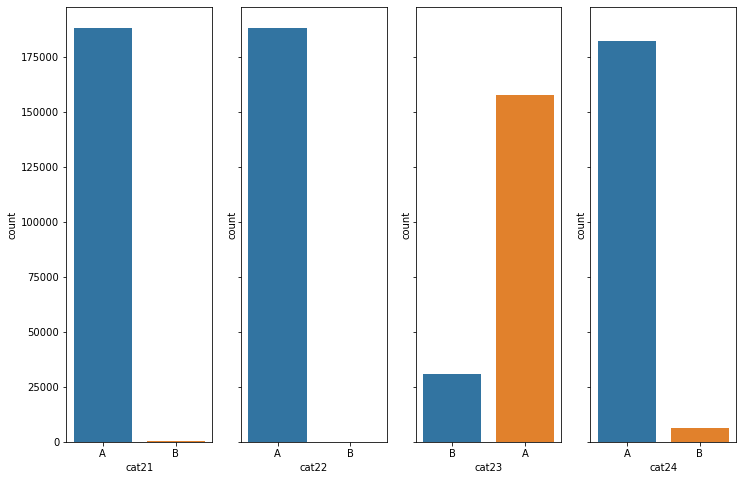

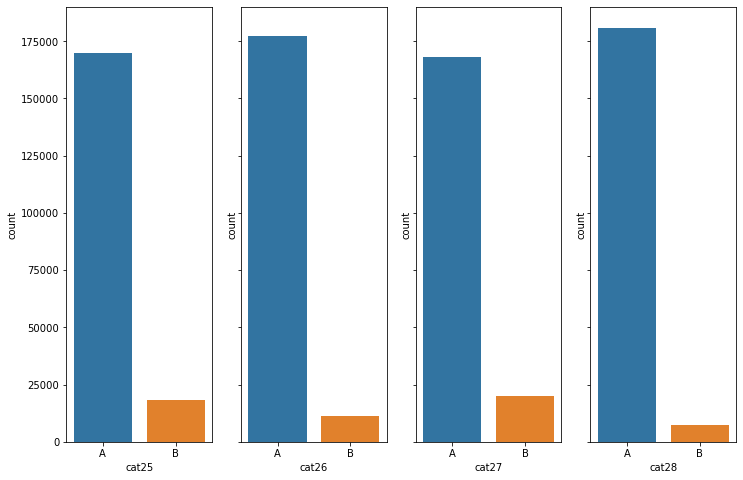

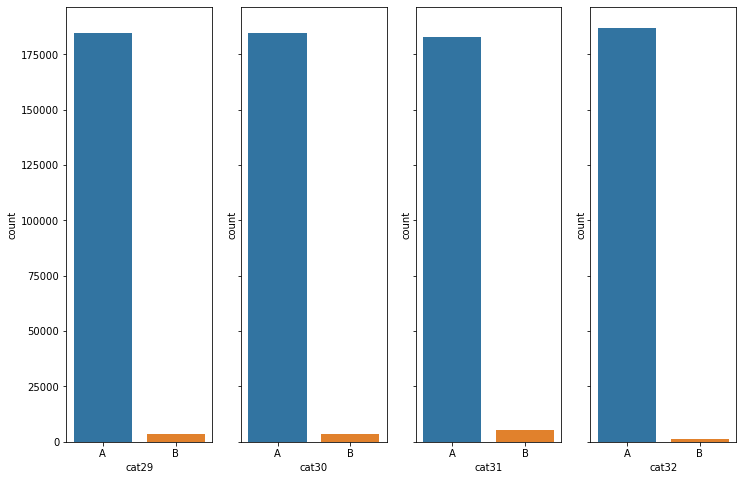

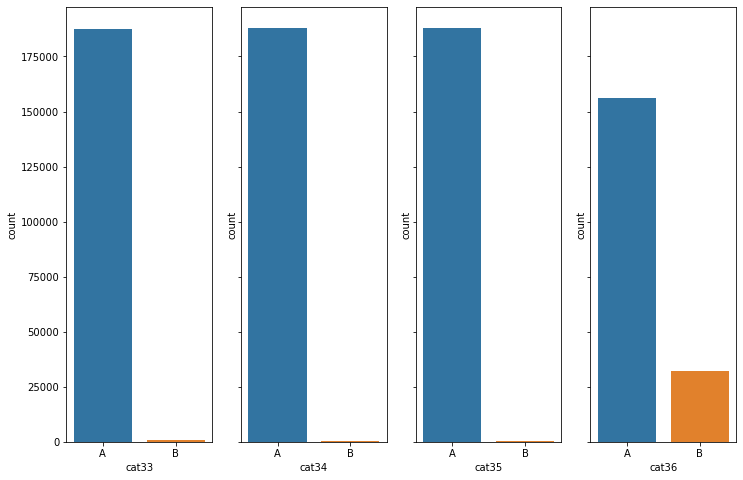

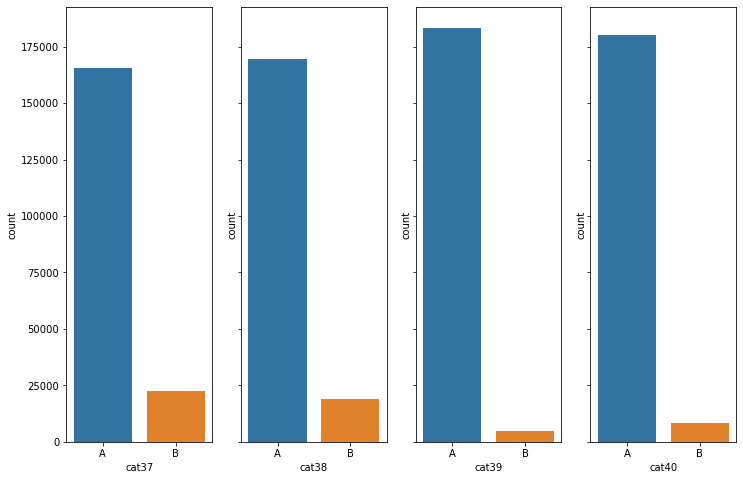

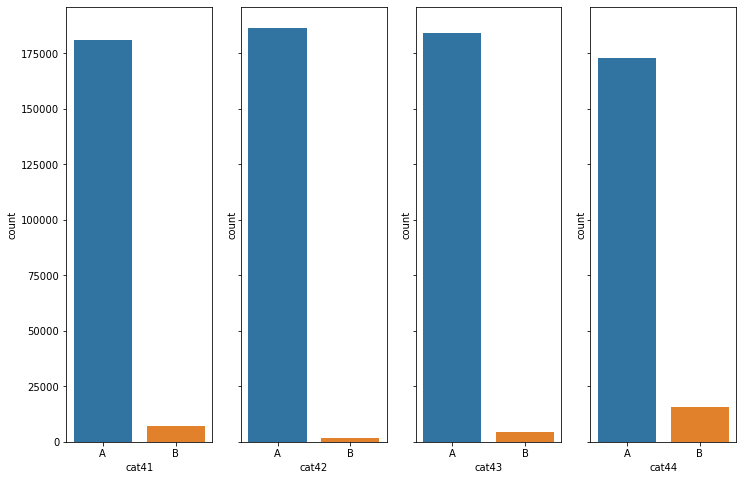

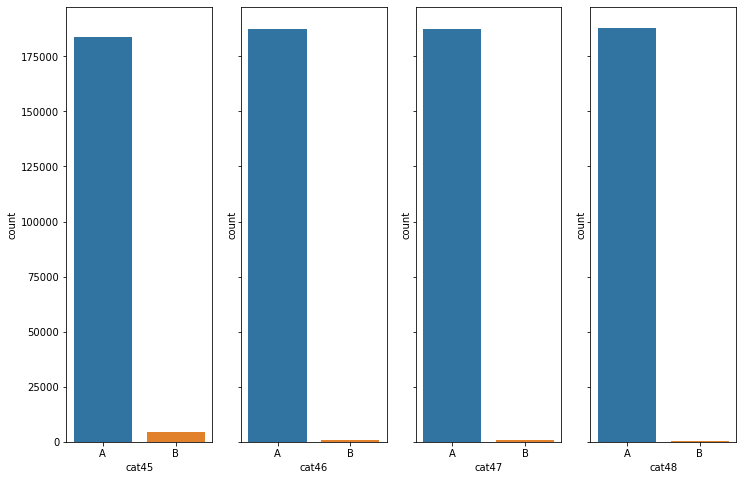

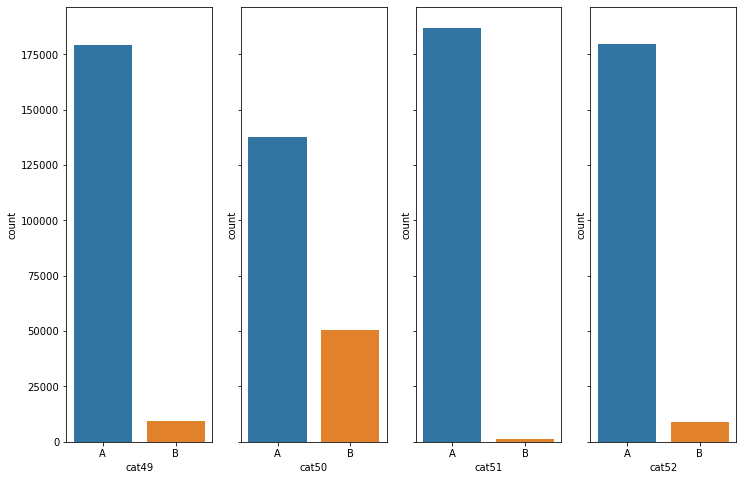

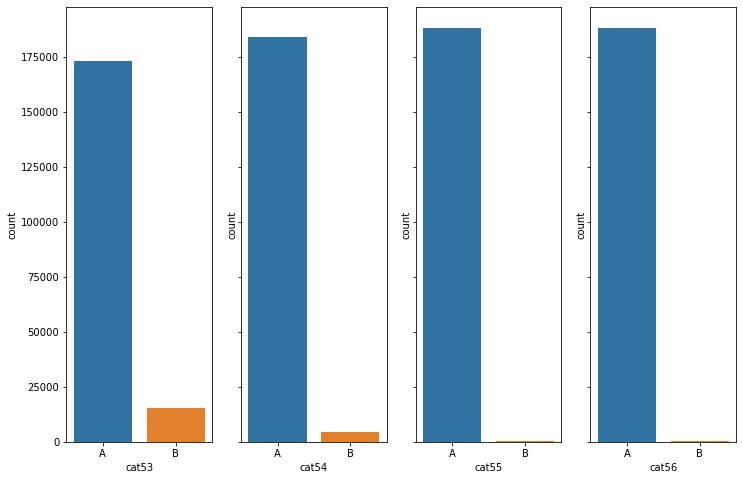

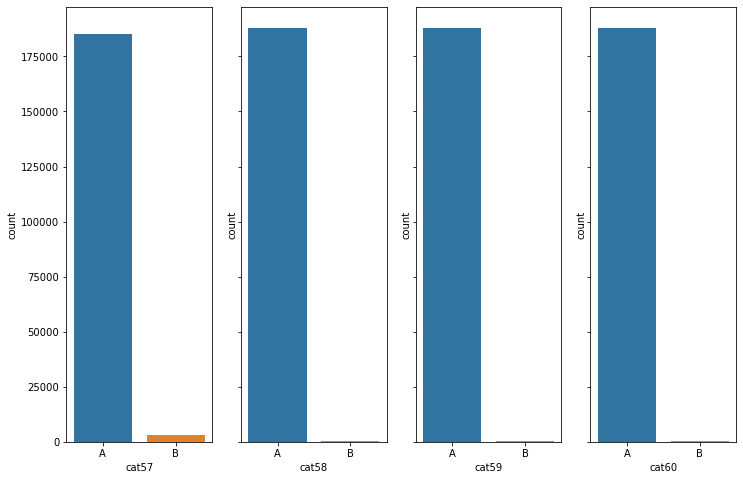

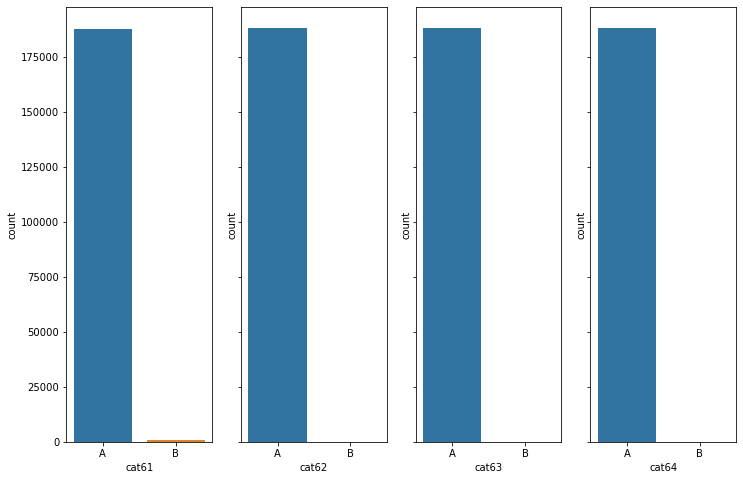

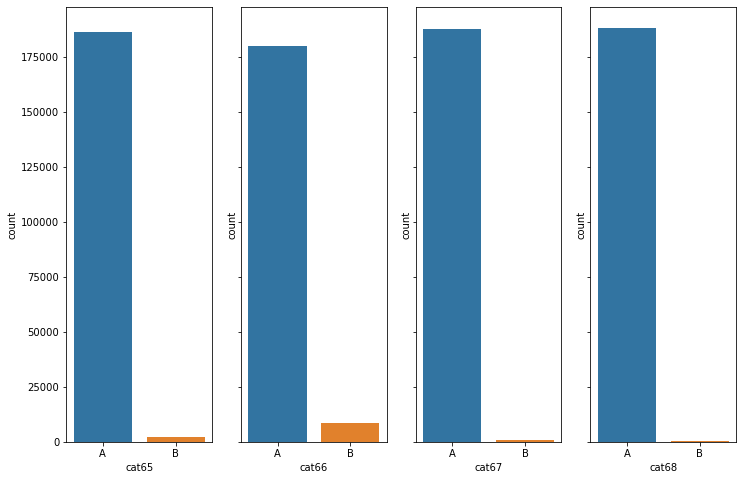

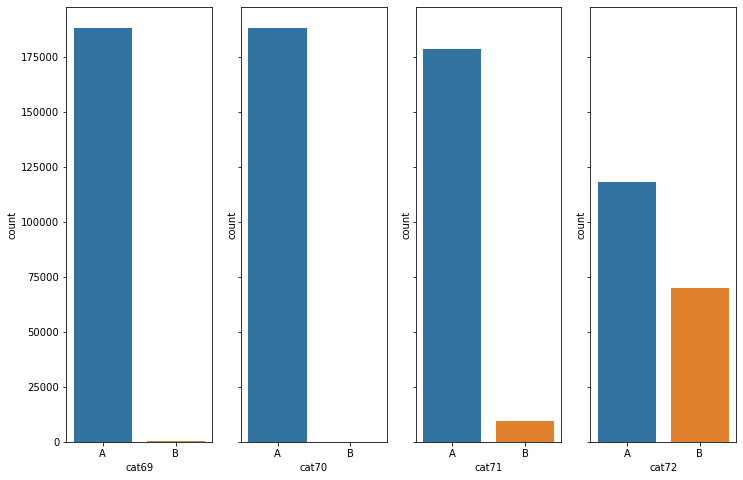

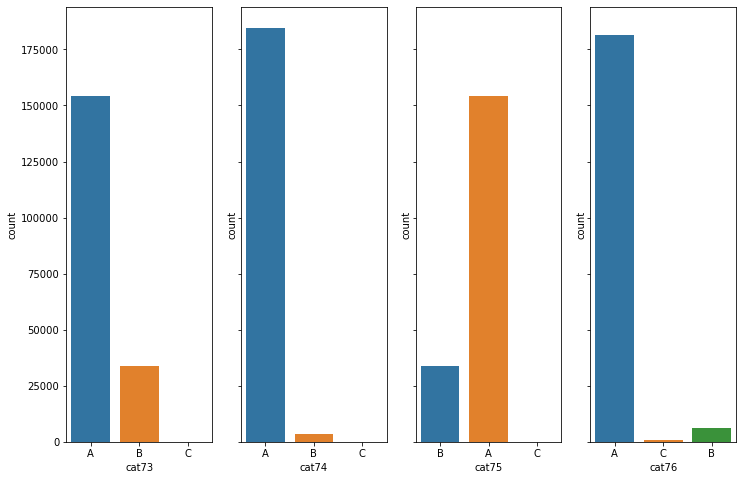

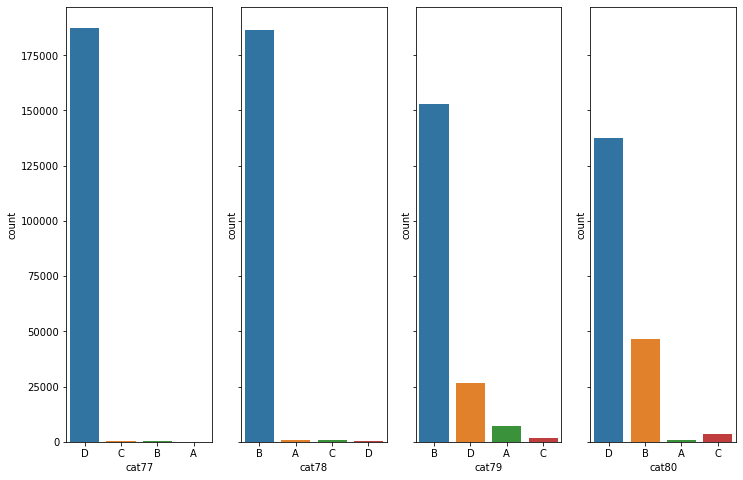

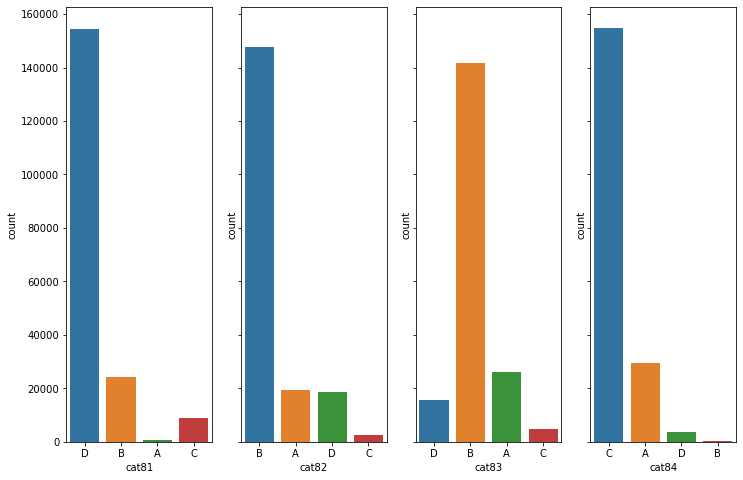

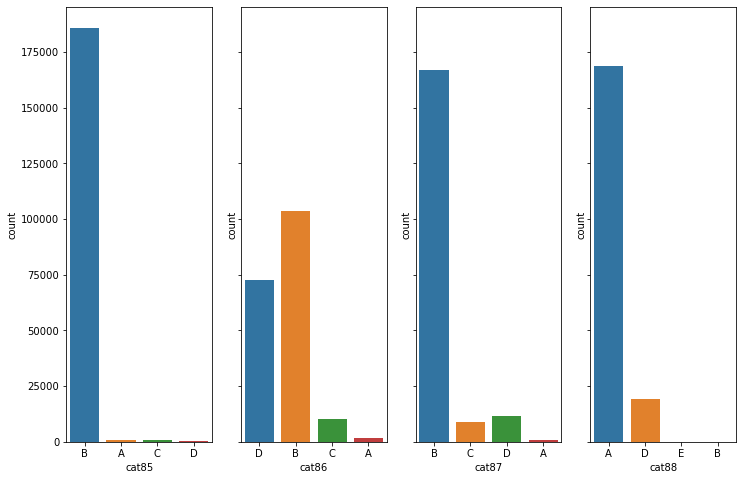

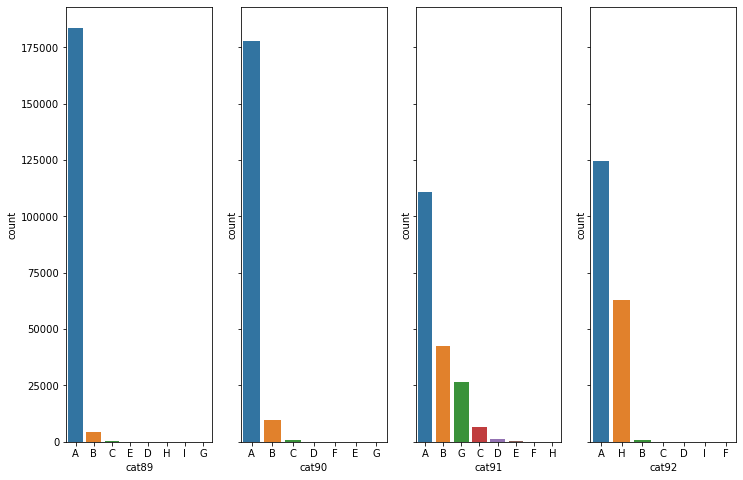

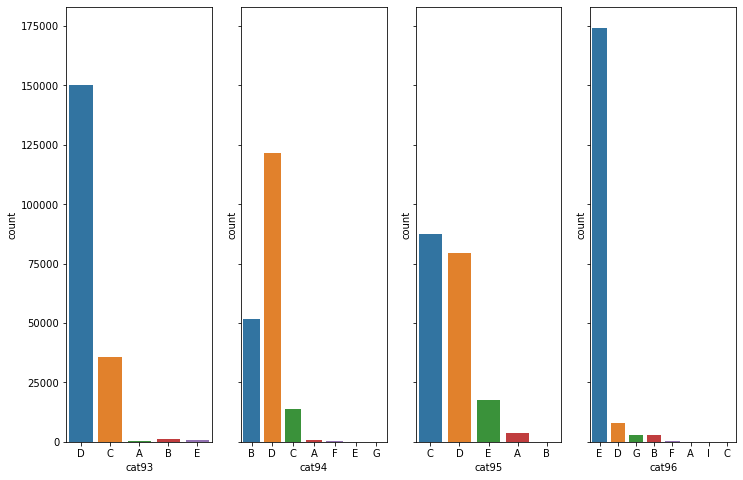

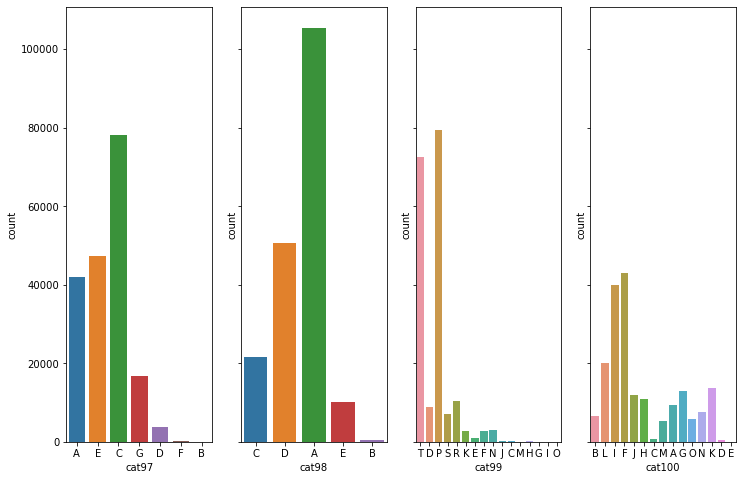

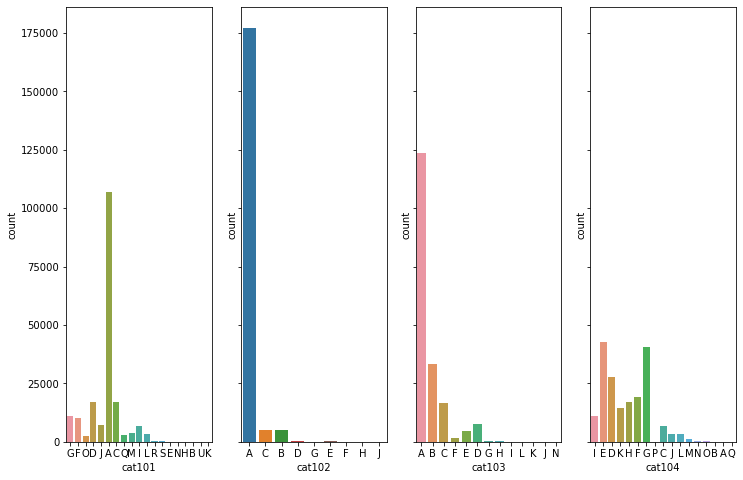

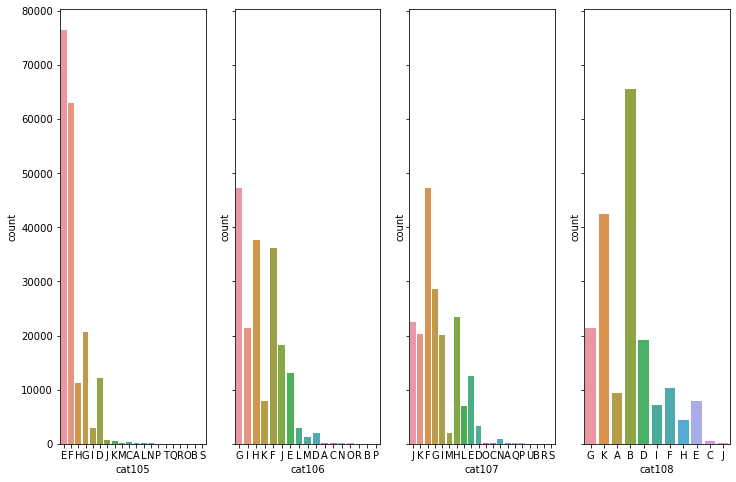

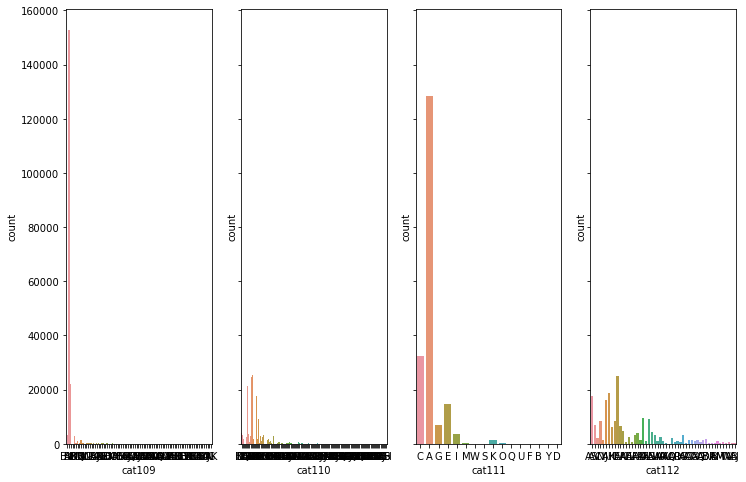

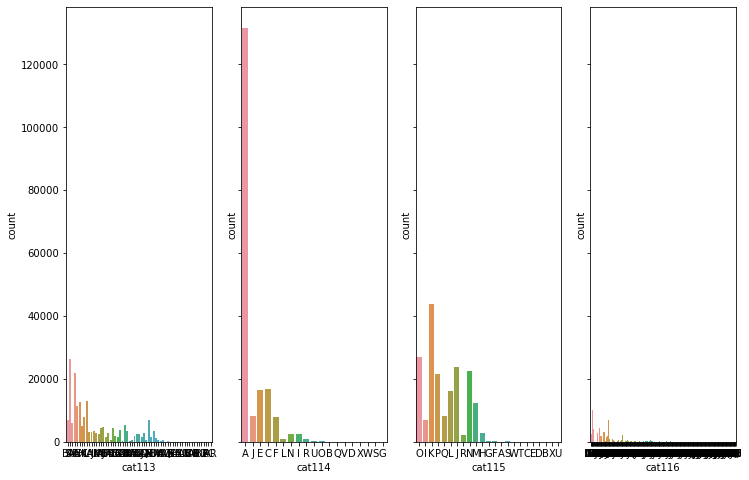

In [16]:
#Plot the distributions
#There are 116 categorical features. We do a 29*4 matrix plot.
train_cols = train_data.columns
m=29
n=4
for i in range(m):
    fig,axis = plt.subplots(nrows=1,ncols=n,sharey=True,figsize=(12, 8))
    for j in range(n):
         sns.countplot(x=cols[i*n+j], data=train_data, ax=axis[j])

Based on the visualiations of the distribution, we drop the features with abnormal distribution.

In [17]:
abonormal_features = ['cat14','cat15','cat18','cat19','cat20','cat21','cat22','cat32','cat33','cat35','cat48','cat55','cat56','cat58',
'cat59','cat60','cat62','cat63','cat64','cat68','cat69','cat70','cat75','cat77']

In [18]:
merged_data_dropped = merged_data_dropped.drop(abonormal_features, axis = 1)

In [19]:
merged_data_dropped.shape

(313864, 100)

The features are selected. Now we need to one hot encode the categorical variables, i.e. create dummy variables.

In [20]:
final_data = pd.get_dummies(merged_data_dropped)

In [21]:
final_data.shape

(313864, 1133)

**Train the model**

In [22]:
train_final = final_data.iloc[:len(train_data)]
test_final = final_data.iloc[len(train_data):].drop("loss", axis = 1)
print(train_final.shape)
print(test_final.shape)


(188318, 1133)
(125546, 1132)


# Base model - Linear Regression Model

In [23]:
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing, metrics 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import decomposition, datasets

In [24]:
X_train = train_final.drop("loss", axis = 1)
Y_train = train_final["loss"]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2,random_state=42)

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_hat = linear_model.predict(x_valid)

In [25]:
from statsmodels.api import OLS
OLS(y_train,x_train).fit().summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   loss   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     183.4
Date:                Wed, 16 Dec 2020   Prob (F-statistic):               0.00
Time:                        04:27:27   Log-Likelihood:            -1.3591e+06
No. Observations:              150654   AIC:                         2.720e+06
Df Residuals:                  149739   BIC:                         2.729e+06
Df Model:                         914                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
id          9.445e-06   3.07e-05      0.308      0.758   -5.07e-05    6.96e-05
cont2       1461.8323     52.958     27.604      0.000    1358.036    1565.629
cont3        705.5240    164.436      4.291      0.000     383.233    1027.815
cont4         99.7844    144.594      0.690      0.490    -183.617     383.186
cont7        834.4155    122.252      6.825      0.000     594.805    1074.026
cont8        247.5011     66.145      3.742      0.000     117.858     377.144
cont12      -256.9654    265.909     -0.966      0.334    -778.142     264.211
cat1_A       307.4250     15.616     19.687      0.000     276.819     338.031
cat1_B        57.0188     15.797      3.610      0.000      26.058      87.980
cat2_A      -864.6758    124.581     -6.941      0.000   -1108.852    -620.500
cat2_B      1229.1195    127.893      9.610      0.000     978.451    1479.788
cat3_A       602.8019     98.326      6.131      0.000     410.085     795.519
cat3_B      -238.3582    104.860     -2.273      0.023    -443.882     -32.835
cat4_A      -948.9831    121.261     -7.826      0.000   -1186.653    -711.313
cat4_B      1313.4268    122.759     10.699      0.000    1072.822    1554.032
cat5_A      -841.1706    301.696     -2.788      0.005   -1432.489    -249.853
cat5_B      1205.6143    294.855      4.089      0.000     627.704    1783.525
cat6_A      -352.1472    140.203     -2.512      0.012    -626.942     -77.353
cat6_B       716.5910    140.680      5.094      0.000     440.861     992.321
cat7_A       311.2058    145.604      2.137      0.033      25.825     596.587
cat7_B        53.2379    154.659      0.344      0.731    -249.891     356.367
cat8_A      -120.8616     82.828     -1.459      0.145    -283.203      41.480
cat8_B       485.3053     87.319      5.558      0.000     314.163     656.448
cat9_A       415.9209     49.808      8.350      0.000     318.298     513.544
cat9_B       -51.4771     49.508     -1.040      0.298    -148.512      45.558
cat10_A      337.7391     49.730      6.792      0.000     240.270     435.208
cat10_B       26.7047     49.522      0.539      0.590     -70.358     123.768
cat11_A      354.3570     49.689      7.131      0.000     256.967     451.747
cat11_B       10.0867     49.500      0.204      0.839     -86.933     107.106
cat12_A       56.7084     49.990      1.134      0.257     -41.272     154.689
cat12_B      307.7353     49.798      6.180      0.000     210.133     405.338
cat13_A      353.9777     49.679      7.125      0.000     256.607     451.348
cat13_B       10.4661     49.512      0.211      0.833     -86.577     107.509
cat16_A      266.9972     29.433      9.071      0.000     209.309     324.685
cat16_B       97.4466     29.432      3.311      0.001      39.760     155.133
cat17_A      106.3792     41.835      2.543      0.011      24.383     188.375
ca

In [26]:
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat - y_valid))))
print("R-squared: {:.2f}".format(linear_model.score(x_valid, y_valid)))

Mean abs error: 1292.29
R-squared: 0.50


Create Base Model Submission File

In [27]:
y_submit = linear_model.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = y_submit
submission.to_csv("submission_basemodel.csv", index = False)

# Model 1.0 - Linear Regression with Log Transformation(Log-Linear)
In the beginning of the EDA, we talked about how log transforamtion corrected the skewness of the 'loss' value.\
Now we can try modify the baseline model with log-transformed 'loss' column.

In [28]:
X_train = train_final.drop("loss", axis = 1)
Y_train_log = np.log1p(train_final["loss"])
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train_log, test_size = 0.2,random_state=42)

log_linear_model = LinearRegression()
log_linear_model.fit(x_train, y_train)
y_hat_log = log_linear_model.predict(x_valid)
#Take the antilog of the predicted value to get true predicted and validation value
y_hat_true = np.exp(1)**y_hat_log
y_valid_true = np.exp(1)**y_valid

In [29]:
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat_true - y_valid_true))))
print("R-squared: {:.2f}".format(log_linear_model.score(x_valid, y_valid)))

Mean abs error: 1247.39
R-squared: 0.52


Create submission file for Model 1.0

In [30]:
y_submit_log_linear = log_linear_model.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = np.exp(1)**y_submit_log_linear
submission.to_csv("submission_log_linear_model.csv", index = False)

# Model 2.0 - Lasso Regression with Log-transformation

In [31]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [32]:
X_train = train_final.drop("loss", axis = 1)
Y_train_log = np.log1p(train_final["loss"])
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train_log, test_size = 0.2,random_state=42)

In [33]:
#Build ML pipeline
sc = RobustScaler()
scores = make_scorer(mean_absolute_error, greater_is_better=False)
pipe = Pipeline([('prepare', sc), ('predict', Lasso())])
#Parameter Tuning
#lasso_params = {'predict__alpha':[0.0005, 0.0007, 0.005, 0.02, 0.03, 0.05, 0.06]}
lasso_params = {'predict__alpha':[0.0005]}#0.0005 is the best after parameter tuning 
GridSearch = GridSearchCV(pipe, param_grid=lasso_params, scoring=scores, cv = 5, verbose=1)

In [34]:
GridSearch.fit(x_train, y_train)
results = GridSearch.cv_results_
#Display the best parameter
sorted([((-scores), param) for scores, param in zip(results['mean_test_score'], results['params'])], reverse=False)[:10]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished


[(0.44384502904859124, {'predict__alpha': 0.0005})]

In [35]:
y_hat_lasso = GridSearch.best_estimator_.predict(x_valid)
y_hat_lasso_true = np.exp(1)**y_hat_lasso
y_valid_true = np.exp(1)**y_valid
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat_lasso_true - y_valid_true))))
print("R-squared: {:.2f}".format(GridSearch.best_estimator_.score(x_valid, y_valid)))

Mean abs error: 1245.01
R-squared: 0.51


Slight improvement over OLS

Create Submission file for model 2.0

In [36]:
y_submit_2_0 = GridSearch.best_estimator_.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = np.exp(1)**y_submit_2_0
submission.to_csv("submission_model_2.0.csv", index = False)

# Model 3.0 - Ridge Regression with Log Transformation

In [37]:
from sklearn.linear_model import Ridge

In [38]:
X_train = train_final.drop("loss", axis = 1)
Y_train_log = np.log1p(train_final["loss"])
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train_log, test_size = 0.2,random_state=42)

In [39]:
#Build ML pipeline
sc = RobustScaler()
scores = make_scorer(mean_absolute_error, greater_is_better=False)
pipe_ridge = Pipeline([('prepare', sc), ('predict', Ridge())])
#Parameter Tuning
#ridge_params = {'predict__alpha':[530, 550, 580, 600, 620, 640]}
ridge_params = {'predict__alpha':[530]} #530 is the best after parameter tuning  
GridSearch_Ridge = GridSearchCV(pipe_ridge, param_grid=ridge_params, scoring=scores, cv = 5, verbose=1)

In [40]:
GridSearch_Ridge.fit(x_train, y_train)
results = GridSearch_Ridge.cv_results_
#Display the best parameter
sorted([((-scores), param) for scores, param in zip(results['mean_test_score'], results['params'])], reverse=False)[:10]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.2s finished


[(0.44231963402863494, {'predict__alpha': 530})]

In [41]:
y_hat_ridge = GridSearch_Ridge.best_estimator_.predict(x_valid)
y_hat_ridge_true = np.exp(1)**y_hat_ridge
y_valid_true = np.exp(1)**y_valid
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat_ridge_true - y_valid_true))))
print("R-squared: {:.2f}".format(GridSearch_Ridge.best_estimator_.score(x_valid, y_valid)))

Mean abs error: 1244.13
R-squared: 0.52


Create submission file for model 3.0

In [42]:
y_submit_3_0 = GridSearch_Ridge.best_estimator_.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = np.exp(1)**y_submit_3_0
submission.to_csv("submission_model_3.0.csv", index = False)

# Model 4.0 - XGBooster

XGBooster, often referred to as Extreme Gradient Boosting, is a very popular ML algorithm to apply on large, complicated data.
We will implement this algorithm and we expect it to greatly improve the model performance. 

In [43]:
import xgboost as xgb

In [44]:
X_train = train_final.drop("loss", axis = 1)
Y_train_log = np.log1p(train_final["loss"])
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train_log, test_size = 0.2,random_state=42)

Due to limited computing power, we choose to not use GridSearch for parameter tuning. We choose the parameters that are commonly used in XGB.

In [45]:
model_4_0 = xgb.XGBRegressor(colsample_bytree=0.5, 
                             gamma=0,
                             learning_rate=0.07, 
                             max_depth=12, min_child_weight=1, n_estimators=100,
                             reg_alpha=0.75, 
                             reg_lambda=0.45, 
                             subsample=0.8, 
                             seed=42) 
model_4_0.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [46]:
y_hat_xgb = model_4_0.predict(x_valid)
y_hat_xgb_true = np.exp(1)**y_hat_xgb
y_valid_true = np.exp(1)**y_valid
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat_xgb_true - y_valid_true))))
print("R-squared: {:.2f}".format(model_4_0.score(x_valid, y_valid)))

Mean abs error: 1153.81
R-squared: 0.55


Create submission file for model 4.0

In [47]:
y_submit_4_0 = model_4_0.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = np.exp(1)**y_submit_4_0
submission.to_csv("submission_model_4.0.csv", index = False)

## Model 4.1 - Test a different set of parameters

In [48]:
model_4_1 = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0.05,                 
                 learning_rate=0.07,
                 max_depth=5,
                 min_child_weight=1,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.25,
                 reg_lambda=0.75,
                 subsample=0.5,
                 seed=42)
model_4_1.fit(x_train,y_train)
y_hat_xgb = model_4_1.predict(x_valid)
y_hat_xgb_true = np.exp(1)**y_hat_xgb
y_valid_true = np.exp(1)**y_valid
print("Mean abs error: {:.2f}".format(np.mean(abs(y_hat_xgb_true - y_valid_true))))
print("R-squared: {:.2f}".format(model_4_1.score(x_valid, y_valid)))

Mean abs error: 1146.55
R-squared: 0.56


Create submission file for model 4.1

In [49]:
y_submit_4_1 = model_4_1.predict(test_final)
submission = pd.DataFrame()
submission["id"] = test_data["id"]
submission["loss"] = np.exp(1)**y_submit_4_1
submission.to_csv("submission_model_4.1.csv", index = False)